In [1]:
import pandas as pd
import numpy as np

import torch
from torch import nn 
from torch.utils.data import DataLoader     # 데이터로더는 데이터셋을 iterable하게 감싸는 역할

from torchvision import datasets            # 데이터셋은 샘플과 정답을 저장함
from torchvision.transforms import ToTensor

import clip

from PIL import Image

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

## Our Model

In [8]:
import deeplake
from torchvision import transforms, models

ds_train = deeplake.load('hub://activeloop/pacs-train')
ds_test = deeplake.load('hub://activeloop/pacs-test')

hub://activeloop/pacs-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train
hub://activeloop/pacs-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-test


In [40]:
batch_size = 8

tform = transforms.Compose([
    transforms.RandomRotation(20), # Image augmentation
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    # transforms.Normalize([0.5], [0.5]),
])

train_loader = ds_train.pytorch(num_workers = 0, shuffle = True, 
                                transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})
test_loader = ds_test.pytorch(num_workers = 0, transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})

In [38]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    plt.figure(figsize=(10, 100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

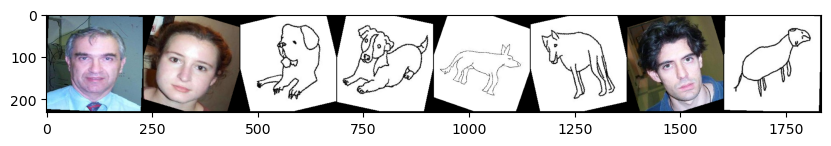

torch.Size([8, 3, 227, 227])


In [41]:
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images, nrow=8))
print(images.shape)

In [94]:
# image data -> iamge_features
# class data -> class_features  (fixed!)
# label data 
# image sim class -> label

def get_image_features(images):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    clip_model, _ = clip.load("ViT-B/32", device=device)

    num_image_layer = clip_model.visual.transformer.layers
    images = images.to(device)

    out_list = []
    x = clip_model.visual.conv1(images.type(clip_model.dtype))
    x = x.reshape(x.shape[0], x.shape[1], -1)   # shape = [*, width, grid ** 2]
    x = x.permute(0, 2, 1)                      # shape = [*, grid ** 2, width]
    x = torch.cat([clip_model.visual.class_embedding.to(x.dtype) + 
                   torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
    x = x + clip_model.visual.positional_embedding.to(x.dtype)
    x = clip_model.visual.ln_pre(x)
    x = x.permute(1, 0, 2)          # NLD -> LND

    for i in range(num_image_layer):
        x = clip_model.visual.transformer.resblocks[i](x)
        tmp = x.permute(1, 0, 2)    # LND -> NLD
        tmp = tmp[:, 0, :].detach()
        out_list.append(tmp)

    image_features = torch.stack(out_list)

    return image_features

def get_text_features(texts):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    clip_model, _ = clip.load("ViT-B/32", device=device)

    num_text_layer = clip_model.transformer.layers
    texts = texts.to(device)

    out_list = []
    x = clip_model.token_embedding(texts).type(clip_model.dtype)  # [batch_size, n_ctx, d_clip_model]
    x = x + clip_model.positional_embedding.type(clip_model.dtype)
    x = x.permute(1, 0, 2)                  # NLD -> LND

    for i in range(num_text_layer):
        x = clip_model.transformer.resblocks[i](x)
        tmp = x.permute(1, 0, 2).detach()   # LND -> NLD
        out_list.append(tmp)

    text_features = torch.stack(out_list)

    return text_features

In [96]:
image_features = get_image_features(images)
image_features.shape

torch.Size([12, 8, 768])

In [99]:
pacs_class = [
    'a dog', 'an elephant', 'a giraffe', 'a guitar', 'a horse', 'a house', 'a person'
]

def prompt(idx):
    return f"An image of {pacs_class[idx]}"

prompts = [prompt(x) for x in range(7)]
class_tokens = clip.tokenize([prompt(x) for x in range(7)]).to(device)
print(prompts)

['An image of a dog', 'An image of an elephant', 'An image of a giraffe', 'An image of a guitar', 'An image of a horse', 'An image of a house', 'An image of a person']


In [102]:
class_features = get_text_features(class_tokens)
class_features.shape

torch.Size([12, 7, 77, 512])

#### inference

In [121]:
image_features2 = clip_model.visual.ln_post(image_features)                   # (12, batch_size, 768)
image_embeddings = image_features2 @ clip_model.visual.proj      # (12, batch_size, 512)  <- we'll use it

class_features2 = clip_model.ln_final(class_features).type(clip_model.dtype)   # (12, seq_len, 77, 512)
class_embeddings = class_features2[:, torch.arange(class_features2.shape[1]), class_tokens.argmax(dim=-1)] @ clip_model.text_projection
                                                                # (12, seq_len, 512)  <- we'll use it

score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
score_tensor = score_tensor.reshape(*score_tensor.shape[:2],-1)


torch.Size([8, 7, 12, 12])

In [136]:
torch.max(score_tensor, dim=-1)[0]
torch.mean(score_tensor, dim=-1)

tensor([[13.3359, 10.3203, 10.1875, 10.7812, 12.9688, 12.1094, 15.3203],
        [14.0703, 10.8203, 10.7031, 11.3125, 13.5156, 12.4766, 16.0312],
        [14.9922, 11.7578, 11.3828, 12.1094, 14.3203, 13.0703, 16.1719],
        [14.7500, 11.4531, 11.0781, 11.5938, 14.0078, 12.6719, 15.6172],
        [14.6641, 11.6250, 11.1953, 11.8828, 14.1562, 12.9375, 15.7031],
        [14.8281, 11.7578, 11.3594, 11.9531, 14.3750, 13.0625, 15.9297],
        [13.3672, 10.2500, 10.0625, 10.9766, 12.9141, 12.0781, 15.2500],
        [15.2656, 12.1094, 11.8281, 12.3516, 14.7578, 13.2578, 16.4062]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward1>)

In [166]:
# Define model
class OurCLIP(nn.Module):        
    def __init__(self, clip_model, # use pre-trained clip model
                 use_one_ln1=True, use_one_ln2=True, 
                 use_one_projection1=True, use_one_projection2=True,
                 trainable_ln1=False, trainable_ln2=False, 
                 trainable_projection1=False, trainable_projection2=False,
                 threshold = 20, score_type=0): 
        super().__init__()

        self.dtype = clip_model.dtype
        self.threshold = threshold
        self.score_type = score_type

        ####################### 미구현
        if use_one_ln1:
            self.ln_post = clip_model.visual.ln_post.requires_grad_(trainable_ln1)
        else: pass
        if use_one_ln2:
            self.ln_final = clip_model.ln_final.requires_grad_(trainable_ln2)
        else: pass
        ########################

        if use_one_projection1:
            self.visual_projection = nn.Parameter(clip_model.visual.proj.clone().detach()).requires_grad_(True)
            if not trainable_projection1:
                self.visual_projection = nn.Parameter(clip_model.visual.proj.clone().detach()).requires_grad_(False)
        else:
            self.visual_projection = nn.Parameter(torch.stack([*[torch.rand(clip_model.visual.proj.shape).to(device) for _ in range(11)],
                                                   clip_model.visual.proj.clone()]).detach()).requires_grad_(True)
        
        if use_one_projection2:
            self.textual_projection = nn.Parameter(clip_model.text_projection.clone().detach()).requires_grad_(True)
            if not trainable_projection2:
                self.textual_projection = nn.Parameter(clip_model.text_projection.clone().detach()).requires_grad_(False)
        else:
            self.textual_projection = nn.Parameter(torch.stack([*[torch.rand(clip_model.text_projection.shape).to(device) for _ in range(11)], 
                                                   clip_model.text_projection.clone()]).detach()).requires_grad_(True)


    def forward(self, image_features, class_features, class_tokens):    
        image_features2 = clip_model.visual.ln_post(image_features)                     # (12, batch_size, 768)
        image_embeddings = image_features2 @ clip_model.visual.proj                     # (12, batch_size, 512)  <- we'll use it

        class_features2 = clip_model.ln_final(class_features).type(clip_model.dtype)    # (12, seq_len, 77, 512)
        class_embeddings = class_features2[:, torch.arange(class_features2.shape[1]), class_tokens.argmax(dim=-1)] @ clip_model.text_projection
                                                                                        # (12, seq_len, 512)  <- we'll use it

        score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
        score_tensor = score_tensor.reshape(*score_tensor.shape[:2],-1)

        if self.score_type == 1:
            return torch.mean(score_tensor, dim=-1)
        if self.score_type == 2:
            return torch.mean(score_tensor, dim=-1) # count score 아직 미구현
        return torch.max(score_tensor, dim=-1)[0]

In [165]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

model = OurCLIP(clip_model, trainable_projection1=True, trainable_projection2=True).to(device)  # model을 initialize하는 부분
print(model)

OurCLIP(
  (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (ln_final): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)


In [164]:
for name, param in model.named_parameters():
    print(name, param.shape)

visual_projection torch.Size([768, 512])
textual_projection torch.Size([512, 512])
ln_post.weight torch.Size([768])
ln_post.bias torch.Size([768])
ln_final.weight torch.Size([512])
ln_final.bias torch.Size([512])


Parameter containing:
tensor([[-0.0104,  0.0142, -0.0084,  ..., -0.0069, -0.0125,  0.0012],
        [ 0.0054,  0.0013, -0.0036,  ...,  0.0026,  0.0136, -0.0201],
        [ 0.0029,  0.0031,  0.0182,  ...,  0.0034,  0.0052, -0.0063],
        ...,
        [ 0.0094,  0.0306,  0.0135,  ...,  0.0160,  0.0014, -0.0110],
        [-0.0113,  0.0047,  0.0017,  ..., -0.0043, -0.0187, -0.0049],
        [ 0.0076, -0.0067,  0.0112,  ...,  0.0036, -0.0038,  0.0170]],
       device='cuda:0', dtype=torch.float16, requires_grad=True)

## Train

In [401]:
import time

def train_one_epoch(model, optimizer, data_loader, device, prompts):

    model.train()

    # Zero the performance stats for each epoch
    running_loss = 0.0
    start_time = time.time()
    total = 0
    correct = 0
    
    for i, data in enumerate(data_loader):
        images = data['images']
        labels = torch.squeeze(data['labels'])

        images = images.to(device)
        labels = labels.to(device)

        image_features = get_image_features(images)
        
        optimizer.zero_grad()
        
        output = model(image_features, class_features, class_tokens)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.argmax(output)
        # print(i, '='*5, predicted, labels)
        total += 1  ########################## labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
        # Print performance statistics
        running_loss += loss.item()
        if i % 10 == 0:    # print every 10 batches
            batch_time = time.time()
            speed = (i+1)/(batch_time-start_time)
            print('[%5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                  (i, running_loss, speed, accuracy))

            running_loss = 0.0
            total = 0
            correct = 0
            # break
        if i != 0 and i % 3000 == 0:
            break;

    
def test_model(model, data_loader):

    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # get the images; data is a list of [images, labels]
            images = data['images']
            labels = torch.squeeze(data['labels'])

            images = images.to(device)
            labels = labels.to(device)

            image_features = get_image_features_per_layer(clip_model, images)
            text_features = get_text_features_per_layer(clip_model, prompts)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if model.score_type == 0:
                output = model(image_features, prompts, text_features)[0]
            elif model.score_type == 1:
                output = model(image_features, prompts, text_features)
            else: assert("미구현")
            # outputs = torch.Tensor(list(map(lambda x: x[0], output))).to(device)

            predicted = torch.argmax(output)
            total += 1 ########################## labels.size(0)
            correct += (predicted == labels).sum().item()
        
            if i != 0 and i % 100 == 0:
                break
        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))

### lab

In [289]:
data = next(iter(train_loader))
inputs = data['images']
labels = torch.squeeze(data['labels'])

inputs = inputs.to(device)
labels = labels.to(device)
labels

tensor(2, device='cuda:0')

In [287]:
inputs.shape, prompts.shape
get_image_features_per_layer(clip_model, inputs).shape, get_text_features_per_layer(clip_model, prompts).shape

(torch.Size([12, 1, 768]), torch.Size([12, 7, 77, 512]))

In [107]:
image_features = get_image_features_per_layer(clip_model, inputs)
text_features = get_text_features_per_layer(clip_model, prompts)

In [290]:
output = model(image_features, prompts, text_features)
output

torch.return_types.max(
values=tensor([1.3213, 1.2870, 0.9971, 0.9502, 1.3020, 1.6231, 1.1956],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([141, 139, 139, 138, 139, 143, 142], device='cuda:0'))

In [126]:
# outputs = torch.Tensor(list(map(lambda x: x[0], scores))).to(device)
# outputs, labels

(tensor([[33.2395, 28.6383, 27.9835, 37.3564, 32.7737, 30.8021, 35.0590],
         [33.6642, 28.3727, 27.1275, 25.2947, 40.4309, 29.3082, 34.7931],
         [33.8334, 29.4328, 28.4747, 37.0757, 34.1582, 29.9939, 36.0595],
         [33.4167, 37.2045, 26.9609, 24.3298, 32.5465, 29.5641, 35.3329]],
        device='cuda:0'),
 tensor([3, 4, 3, 1], device='cuda:0'))

In [292]:
loss = criterion(output[0], labels)
loss

tensor(2.2104, device='cuda:0', grad_fn=<NllLossBackward0>)

In [128]:
torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([37.3564, 40.4309, 37.0757, 37.2045], device='cuda:0'),
indices=tensor([3, 4, 3, 1], device='cuda:0'))

### inference

In [420]:
# train all by one tensor / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 3
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, optimizer, train_loader, device, prompts)

    test_model(model, test_loader)

print('Finished Training')

------------------ Training Epoch 1 ------------------
[    0] loss: 1.482, speed: 0.05, accuracy: 100.00 %
[   10] loss: 14.675, speed: 0.55, accuracy: 90.00 %
[   20] loss: 14.948, speed: 0.99, accuracy: 100.00 %
[   30] loss: 14.323, speed: 1.36, accuracy: 100.00 %
[   40] loss: 14.897, speed: 1.69, accuracy: 100.00 %
[   50] loss: 15.437, speed: 1.98, accuracy: 100.00 %
[   60] loss: 14.796, speed: 2.25, accuracy: 80.00 %
[   70] loss: 15.336, speed: 2.48, accuracy: 100.00 %
[   80] loss: 15.057, speed: 2.69, accuracy: 100.00 %
[   90] loss: 14.951, speed: 2.89, accuracy: 100.00 %
[  100] loss: 14.955, speed: 3.06, accuracy: 90.00 %
[  110] loss: 14.965, speed: 3.22, accuracy: 100.00 %
[  120] loss: 15.409, speed: 3.36, accuracy: 90.00 %
[  130] loss: 14.486, speed: 3.49, accuracy: 100.00 %
[  140] loss: 14.172, speed: 3.61, accuracy: 100.00 %
[  150] loss: 15.129, speed: 3.73, accuracy: 100.00 %
[  160] loss: 14.910, speed: 3.84, accuracy: 100.00 %
[  170] loss: 14.614, speed: 3.9

KeyboardInterrupt: 

In [404]:
# train all by one tensor / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=1).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.1)

num_epochs = 2

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, optimizer, train_loader, device, prompts)

    test_model(model, test_loader)

print('Finished Training')

------------------ Training Epoch 1 ------------------
[    0] loss: 1.957, speed: 0.06, accuracy: 0.00 %
[   10] loss: 19.352, speed: 0.62, accuracy: 10.00 %
[   20] loss: 19.253, speed: 1.10, accuracy: 30.00 %
[   30] loss: 19.116, speed: 1.50, accuracy: 10.00 %
[   40] loss: 19.115, speed: 1.86, accuracy: 20.00 %
[   50] loss: 19.086, speed: 2.17, accuracy: 10.00 %
[   60] loss: 19.234, speed: 2.44, accuracy: 20.00 %
[   70] loss: 19.171, speed: 2.68, accuracy: 10.00 %
[   80] loss: 19.221, speed: 2.90, accuracy: 0.00 %
[   90] loss: 19.153, speed: 3.10, accuracy: 20.00 %
[  100] loss: 19.284, speed: 3.28, accuracy: 0.00 %
[  110] loss: 19.204, speed: 3.44, accuracy: 10.00 %
[  120] loss: 19.315, speed: 3.59, accuracy: 20.00 %
[  130] loss: 19.096, speed: 3.72, accuracy: 10.00 %
[  140] loss: 19.288, speed: 3.85, accuracy: 0.00 %
[  150] loss: 19.274, speed: 3.97, accuracy: 0.00 %
[  160] loss: 19.367, speed: 4.07, accuracy: 10.00 %
[  170] loss: 19.269, speed: 4.17, accuracy: 30.00

In [419]:
# train all by each tensor / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 3

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, optimizer, train_loader, device, prompts)

    test_model(model, test_loader)

print('Finished Training')

------------------ Training Epoch 1 ------------------
[    0] loss: 1.944, speed: 0.08, accuracy: 0.00 %
[   10] loss: 19.566, speed: 0.76, accuracy: 0.00 %
[   20] loss: 19.425, speed: 1.32, accuracy: 0.00 %
[   30] loss: 19.506, speed: 1.78, accuracy: 0.00 %
[   40] loss: 19.524, speed: 2.17, accuracy: 0.00 %
[   50] loss: 19.489, speed: 2.51, accuracy: 0.00 %
[   60] loss: 19.412, speed: 2.80, accuracy: 0.00 %
[   70] loss: 19.386, speed: 3.05, accuracy: 0.00 %
[   80] loss: 19.382, speed: 3.27, accuracy: 0.00 %
[   90] loss: 19.489, speed: 3.47, accuracy: 0.00 %
[  100] loss: 19.463, speed: 3.65, accuracy: 0.00 %
[  110] loss: 19.475, speed: 3.81, accuracy: 0.00 %
[  120] loss: 19.470, speed: 3.95, accuracy: 0.00 %
[  130] loss: 19.506, speed: 4.08, accuracy: 0.00 %
[  140] loss: 19.424, speed: 4.20, accuracy: 0.00 %
[  150] loss: 19.535, speed: 4.30, accuracy: 20.00 %
[  160] loss: 19.492, speed: 4.41, accuracy: 0.00 %
[  170] loss: 19.353, speed: 4.50, accuracy: 0.00 %
[  180] l

In [423]:
clip_model.visual.proj, model.visual_projection.requires_grad

(Parameter containing:
 tensor([[-2.6264e-03,  5.0962e-05,  2.7496e-02,  ..., -1.0025e-02,
          -1.2222e-02,  5.8403e-03],
         [-1.9852e-02,  7.1182e-03,  8.9788e-04,  ...,  1.1528e-02,
          -1.9485e-02, -8.0185e-03],
         [-8.6288e-03,  1.9226e-03, -2.1725e-03,  ...,  3.9330e-03,
          -1.1269e-02,  1.5345e-03],
         ...,
         [-1.1993e-02,  1.2955e-02,  2.5848e-02,  ..., -9.8038e-03,
          -4.2076e-03,  1.5211e-04],
         [-1.2871e-02, -9.5673e-03, -1.0826e-02,  ..., -7.0610e-03,
          -4.3182e-03, -4.9353e-04],
         [-4.4098e-03,  3.3588e-03, -1.2054e-02,  ...,  6.1073e-03,
           3.9940e-03, -3.0861e-03]], device='cuda:0', dtype=torch.float16,
        requires_grad=True),
 tensor([[-2.6264e-03,  5.0962e-05,  2.7496e-02,  ..., -1.0025e-02,
          -1.2222e-02,  5.8403e-03],
         [-1.9852e-02,  7.1182e-03,  8.9788e-04,  ...,  1.1528e-02,
          -1.9485e-02, -8.0185e-03],
         [-8.6288e-03,  1.9226e-03, -2.1725e-03,  ..., 

In [ ]:
# zeroshot
def test_model_for_clip_model(clip_model, data_loader):

    clip_model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['images']
            labels = torch.squeeze(data['labels'])
        
            inputs = inputs.to(device)
            labels = labels.to(device)

            # inputs = inputs.permute([0, 3, 1, 2])   # N, H, W, C -> N, C, H, W

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = clip_model(inputs, prompts)[0].softmax(dim=-1)
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))

In [ ]:
test_model_for_clip_model(clip_model, test_loader)